# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [2]:
# import package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

In [3]:
#read in the data for 000098
data1 = pd.read_csv('PS1_PS1MD_PSc000098.snana.dat',header = 15,sep = ' ',names = ['MJD','FLT','?','FIELD','FLUCAL','FLUXCALERR','MAG','MAGERR'])
data1 = data1.drop('?', axis=1)
data1 = data1.drop('END:',axis = 0)
data1

,MJD,FLT,FIELD,FLUCAL,FLUXCALERR,MAG,MAGERR
OBS:,54993.3,g,NaN,-3.994,12.945,NaN,-3.519
OBS:,54996.3,g,NaN,-17.450,14.218,NaN,-0.885
OBS:,54999.3,g,NaN,25.615,15.484,-8.521,0.656
OBS:,55002.3,g,NaN,20.129,15.184,-8.260,0.819
OBS:,55191.6,g,NaN,9.983,11.099,-7.498,1.207
...,...,...,...,...,...,...,...
OBS:,56453.3,z,NaN,-1.486,30.258,NaN,-22.111
OBS:,56456.3,z,NaN,46.901,27.163,-9.178,0.629
OBS:,56459.3,z,NaN,19.229,26.180,-8.210,1.478
OBS:,56681.6,z,NaN,-9.721,25.122,NaN,-2.806


In [4]:
#read in the data for 000174
data2 = pd.read_csv('PS1_PS1MD_PSc000174.snana.dat',header = 15,sep = ' ',names = ['MJD','FLT','?','FIELD','FLUCAL','FLUXCALERR','MAG','MAGERR'])
data2 = data2.drop('?', axis=1)
data2 = data2.drop('END:',axis = 0)
data2

,MJD,FLT,FIELD,FLUCAL,FLUXCALERR,MAG,MAGERR
OBS:,55173.6,g,NaN,3.271,11.190,-6.287,3.715
OBS:,55182.6,g,NaN,-3.600,8.943,NaN,-2.697
OBS:,55188.6,g,NaN,-1.560,10.123,NaN,-7.045
OBS:,55191.6,g,NaN,0.170,10.314,-3.077,65.835
OBS:,55203.5,g,NaN,84.803,10.756,-9.821,0.138
...,...,...,...,...,...,...,...
OBS:,56421.3,z,NaN,-13.425,21.688,NaN,-1.754
OBS:,56423.3,z,NaN,-36.367,23.663,NaN,-0.706
OBS:,56429.3,z,NaN,-8.987,21.036,NaN,-2.541
OBS:,56437.3,z,NaN,53.441,65.522,-9.320,1.331


In [5]:
#seperate the data into different bands
data1_g =data1[data1['FLT']=='g']
data1_r =data1[data1['FLT']=='r']
data1_i =data1[data1['FLT']=='i']
data1_z =data1[data1['FLT']=='z']
data2_g =data2[data2['FLT']=='g']
data2_r =data2[data2['FLT']=='r']
data2_i =data2[data2['FLT']=='i']
data2_z =data2[data2['FLT']=='z']

In [130]:
# define the model
def model(theta,t):
    gamma,A,beta,t0,tau_rise,tau_fall = theta
    t1 = gamma+t0
    flux = np.zeros(len(t))
    if (tau_rise == 0) or (tau_fall == 0):
        return flux
    else:
        for i in range(len(t)):
            if t[i] < t1:
                flux[i] = (A+beta*(t[i]-t0))/(1+np.exp((-t[i]+t0)/tau_rise))
            if t[i] >= t1:
                flux[i] = ((A+beta*(t1-t0))*np.exp((-t[i]+t1)/tau_fall))/(1+np.exp((-t[i]+t0)/tau_rise))
        return flux

In [38]:
#define priors

def log_prior(theta):
    tmin = min(data['MJD'])
    tmax = max(data['MJD'])
    fmax = max(data['FLUCAL'])
    gamma,A,beta,t0,tau_rise,tau_fall = theta
    t1 = gamma+t0
    if (tau_rise>0.01) and (tau_rise<50):
        #p_tau_rise = np.log(1/(50-0.01))
        p_tau_rise = st.norm.pdf(tau_rise, loc = 1.55864126e+00, scale = 3)
        
        if (tau_fall>1) and (tau_fall<300):
            #p_tau_fall = np.log(1/(300-1))
            p_tau_fall = st.norm.pdf(tau_fall, loc = 2.80081876e+01, scale = 5)
            
            if (t0>tmin-50) and (t0<tmax):
                #p_t0 = np.log(1/(tmax-tmin+50))
                p_t0 = st.norm.pdf(t0, loc = 5.52018970e+04, scale = 50)
                
                if (A>0) and (A< 50*fmax):
                    #p_A = np.log(1/(100*fmax))
                    p_A = st.norm.pdf(A, loc = 1.09091716e+03, scale = 50)
                    
                    if (beta > -fmax/150) and (beta<0):
                        #p_beta = np.log(1/(fmax/150))
                        p_beta = st.norm.pdf(beta, loc = -3.21242925e+00, scale = 1)
                        
                        if (t1>tmin-50) and (t1<tmax):
                            p_gamma = (2/3)*st.norm.pdf(gamma, loc = 5, scale = 5) + (1/3)*st.norm.pdf(gamma, loc = 60, scale = 30)
                            #p_gamma = np.log(p_gamma)
                            #p = p_tau_rise+p_tau_fall+p_t0+p_A+p_beta+p_gamma
                            p = np.log(p_tau_rise*p_tau_fall*p_t0*p_A*p_beta*p_gamma)
                            return p
                        else:
                            return -np.inf
                    else:
                        return -np.inf
                else:
                    return -np.inf
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [8]:
# define log_likelihood
def log_likelihood(theta,t,flux,fluxerr):
    flux_pre = model(theta,t)
    dflux = abs(flux_pre-flux)
    likelihood = abs(dflux/fluxerr)
    
    #loglike = - np.log(sum((flux_pre-flux)**2/(2*fluxerr**2)))
    loglike = -2*np.log(sum(likelihood))
    if np.isnan(loglike)==True:
        return -np.inf
    else:
        return loglike

In [9]:
# define posterior
def log_posterior(theta,t,flux,fluxerr):
        return log_prior(theta)+log_likelihood(theta,t,flux,fluxerr)

# 000098

In [92]:
#read in data
data = data1
t = np.array(data['MJD'])
flux = np.array(data['FLUCAL'])
fluxerr = np.array(data['FLUXCALERR'])
args = (t,flux,fluxerr)

In [62]:
#run MCMC
import emcee
ndim = 6  
nwalkers = 20

nburn = 200 
nsteps = 5000 

tmin = min(data['MJD'])
tmax = max(data['MJD'])
fmax = max(data['FLUCAL'])

starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, 0] = (2/3)*np.random.normal(5,5,20)+(1/3)*np.random.normal(60,30,20)
starting_guesses[:, 1] = np.random.normal(loc = 1.09091716e+03, scale = 50,size = 20)
starting_guesses[:, 2] = np.random.normal(loc = -3.21242925e+00, scale = 1,size = 20)
starting_guesses[:, 3] = np.random.normal(loc = 5.52018970e+04, scale = 50,size = 20)
starting_guesses[:, 4] = np.random.normal(loc = 1.55864126e+00, scale = 3,size = 20)
starting_guesses[:, 5] = np.random.normal(loc = 2.80081876e+01, scale = 5,size = 20)

#starting_guesses[:, 1] = np.random.uniform(0,50*fmax,size = 20)
#starting_guesses[:, 2] = np.random.uniform(-fmax/150,0,size = 20)
#starting_guesses[:, 3] = np.random.uniform(tmin-50,tmax,size = 20)
#starting_guesses[:, 4] = np.random.uniform(0.01,50,size = 20)
#starting_guesses[:, 5] = np.random.uniform(1,300,size = 20)

sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=args)
_ =  sampler1.run_mcmc(starting_guesses, nsteps)

/var/folders/qg/_0h7h3ys57s350xzq0ry7w3r0000gn/T/ipykernel_63597/537085638.py:13: RuntimeWarning: overflow encountered in exp
  flux[i] = ((A+beta*(t1-t0))*np.exp((-t[i]+t1)/tau_fall))/(1+np.exp((-t[i]+t0)/tau_rise))
/var/folders/qg/_0h7h3ys57s350xzq0ry7w3r0000gn/T/ipykernel_63597/537085638.py:11: RuntimeWarning: overflow encountered in exp
  flux[i] = (A+beta*(t[i]-t0))/(1+np.exp((-t[i]+t0)/tau_rise))
/var/folders/qg/_0h7h3ys57s350xzq0ry7w3r0000gn/T/ipykernel_63597/537085638.py:13: RuntimeWarning: overflow encountered in double_scalars
  flux[i] = ((A+beta*(t1-t0))*np.exp((-t[i]+t1)/tau_fall))/(1+np.exp((-t[i]+t0)/tau_rise))
/var/folders/qg/_0h7h3ys57s350xzq0ry7w3r0000gn/T/ipykernel_63597/537085638.py:13: RuntimeWarning: invalid value encountered in double_scalars
  flux[i] = ((A+beta*(t1-t0))*np.exp((-t[i]+t1)/tau_fall))/(1+np.exp((-t[i]+t0)/tau_rise))


In [63]:
sample1 = sampler1.chain
sample1 = sampler1.chain[:, nburn:, :].reshape(-1, ndim)

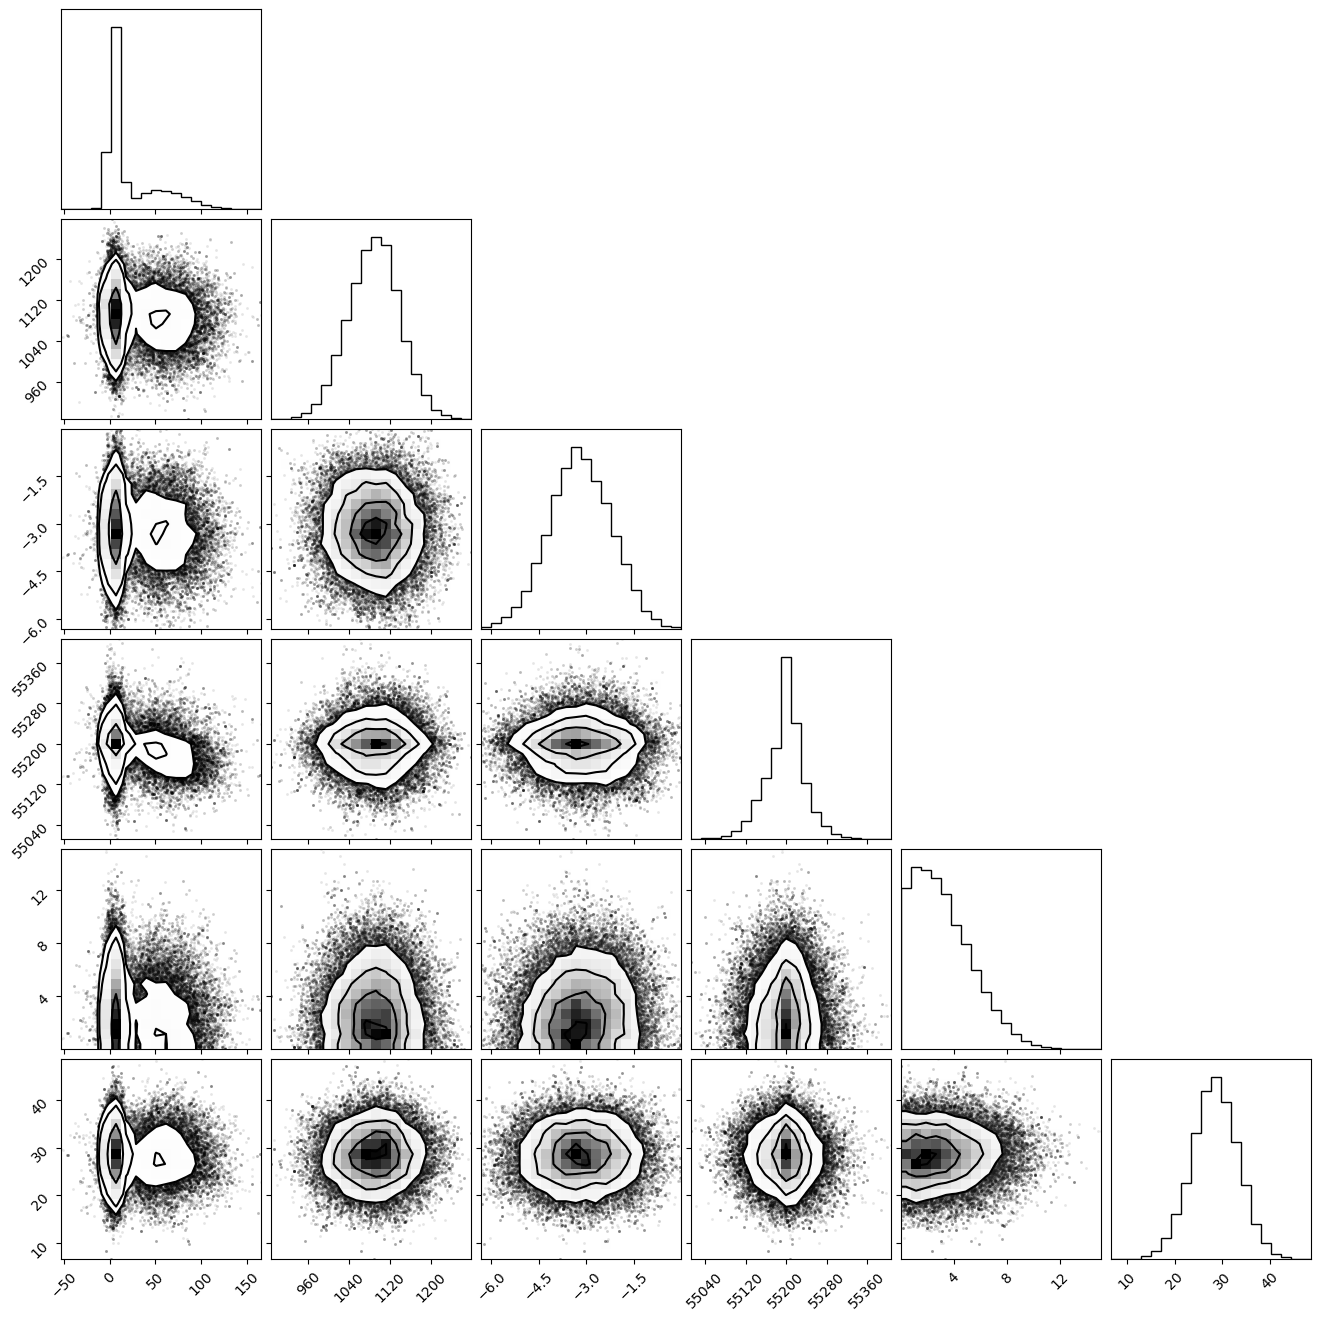

In [64]:
#plot the corner plot
import corner

fig = corner.corner(
    sample1
);

In [90]:
#print the median of all the parameters
print("median of gamma:", np.median(sample1[:,0]))
print("median of A:", np.median(sample1[:,1]))
print("median of beta:", np.median(sample1[:,2]))
print("median of t0:", np.median(sample1[:,3]))
print("median of tau_rise:", np.median(sample1[:,4]))
print("median of tau_fall:", np.median(sample1[:,5]))
theta_pre = [np.median(sample1[:,0]),np.median(sample1[:,1]),np.median(sample1[:,2]),np.mean(sample1[:,3]),np.median(sample1[:,4]),np.median(sample1[:,5])]

median of gamma: 8.311074092321356
median of A: 1088.950986698905
median of beta: -3.203781540457948
median of t0: 55200.65625733718
median of tau_rise: 2.8476972286274425
median of tau_fall: 28.39418439405069


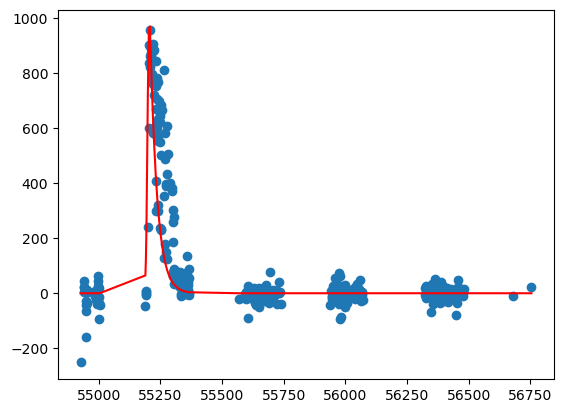

In [93]:
plt.plot(sorted(t),model(theta_pre,sorted(t)),color='r')
plt.scatter(t,flux)

In [ ]:
autocorr = emcee.autocorr.integrated_time(sampler1.get_chain())
autocorr_thin = emcee.autocorr.integrated_time(sampler1.get_chain()[0::10])

In [76]:
print('autocorelation length:',autocorr)
print('autocorelation length after thining:',autocorr_thin)

autocorelation length: [145.11871802, 73.08378318, 93.99284941, 79.76148019, 84.69344214, 88.95781278]
autocorelation length after thining: [14.54818464, 7.44628143, 9.32315764, 7.98054896, 8.39368808, 8.89297418]


## 000174

In [113]:
data = data2
t = np.array(data['MJD'])
flux = np.array(data['FLUCAL'])
fluxerr = np.array(data['FLUXCALERR'])
args = (t,flux,fluxerr)

In [118]:
#define priors

def log_prior(theta):
    tmin = min(data['MJD'])
    tmax = max(data['MJD'])
    fmax = max(data['FLUCAL'])
    gamma,A,beta,t0,tau_rise,tau_fall = theta
    t1 = gamma+t0
    if (tau_rise>0.01) and (tau_rise<50):
        #p_tau_rise = np.log(1/(50-0.01))
        p_tau_rise = st.norm.pdf(tau_rise, loc = 1.55864126e+00, scale = 3)
        
        if (tau_fall>1) and (tau_fall<300):
            #p_tau_fall = np.log(1/(300-1))
            p_tau_fall = st.norm.pdf(tau_fall, loc = 2.80081876e+01, scale = 5)
            
            if (t0>tmin-50) and (t0<tmax):
                #p_t0 = np.log(1/(tmax-tmin+50))
                p_t0 = st.norm.pdf(t0, loc = 55200, scale = 50)
                
                if (A>0) and (A< 50*fmax):
                    #p_A = np.log(1/(100*fmax))
                    p_A = st.norm.pdf(A, loc = 480, scale = 50)
                    
                    if (beta > -fmax/150) and (beta<0):
                        #p_beta = np.log(1/(fmax/150))
                        p_beta = st.norm.pdf(beta, loc = -1.5, scale = 1)
                        
                        if (t1>tmin-50) and (t1<tmax):
                            p_gamma = (2/3)*st.norm.pdf(gamma, loc = 5, scale = 5) + (1/3)*st.norm.pdf(gamma, loc = 60, scale = 30)
                            #p_gamma = np.log(p_gamma)
                            #p = p_tau_rise+p_tau_fall+p_t0+p_A+p_beta+p_gamma
                            p = np.log(p_tau_rise*p_tau_fall*p_t0*p_A*p_beta*p_gamma)
                            return p
                        else:
                            return -np.inf
                    else:
                        return -np.inf
                else:
                    return -np.inf
            else:
                return -np.inf
        else:
            return -np.inf
    else:
        return -np.inf

In [119]:
nburn = 200 
nsteps = 2000 

tmin = min(data['MJD'])
tmax = max(data['MJD'])
fmax = max(data['FLUCAL'])

starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, 0] = (2/3)*np.random.normal(5,5,20)+(1/3)*np.random.normal(60,30,20)
starting_guesses[:, 1] = np.random.normal(loc = 480, scale = 50,size = 20)
starting_guesses[:, 2] = np.random.normal(loc = -1.5, scale = 1,size = 20)
starting_guesses[:, 3] = np.random.normal(loc = 55200, scale = 50,size = 20)
starting_guesses[:, 4] = np.random.normal(loc = 1.55864126e+00, scale = 3,size = 20)
starting_guesses[:, 5] = np.random.normal(loc = 2.80081876e+01, scale = 5,size = 20)

#starting_guesses[:, 1] = np.random.uniform(0,50*fmax,size = 20)
#starting_guesses[:, 2] = np.random.uniform(-fmax/150,0,size = 20)
#starting_guesses[:, 3] = np.random.uniform(tmin-50,tmax,size = 20)
#starting_guesses[:, 4] = np.random.uniform(0.01,50,size = 20)
#starting_guesses[:, 5] = np.random.uniform(1,300,size = 20)

sampler2g = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=args)
_ =  sampler2g.run_mcmc(starting_guesses, nsteps)

/var/folders/qg/_0h7h3ys57s350xzq0ry7w3r0000gn/T/ipykernel_63597/537085638.py:13: RuntimeWarning: overflow encountered in exp
  flux[i] = ((A+beta*(t1-t0))*np.exp((-t[i]+t1)/tau_fall))/(1+np.exp((-t[i]+t0)/tau_rise))
/var/folders/qg/_0h7h3ys57s350xzq0ry7w3r0000gn/T/ipykernel_63597/537085638.py:11: RuntimeWarning: overflow encountered in exp
  flux[i] = (A+beta*(t[i]-t0))/(1+np.exp((-t[i]+t0)/tau_rise))
/var/folders/qg/_0h7h3ys57s350xzq0ry7w3r0000gn/T/ipykernel_63597/537085638.py:13: RuntimeWarning: invalid value encountered in double_scalars
  flux[i] = ((A+beta*(t1-t0))*np.exp((-t[i]+t1)/tau_fall))/(1+np.exp((-t[i]+t0)/tau_rise))
/var/folders/qg/_0h7h3ys57s350xzq0ry7w3r0000gn/T/ipykernel_63597/537085638.py:13: RuntimeWarning: overflow encountered in double_scalars
  flux[i] = ((A+beta*(t1-t0))*np.exp((-t[i]+t1)/tau_fall))/(1+np.exp((-t[i]+t0)/tau_rise))


In [120]:
sample2 = sampler2g.chain
sample2 = sampler2g.chain[:, nburn:, :].reshape(-1, ndim)

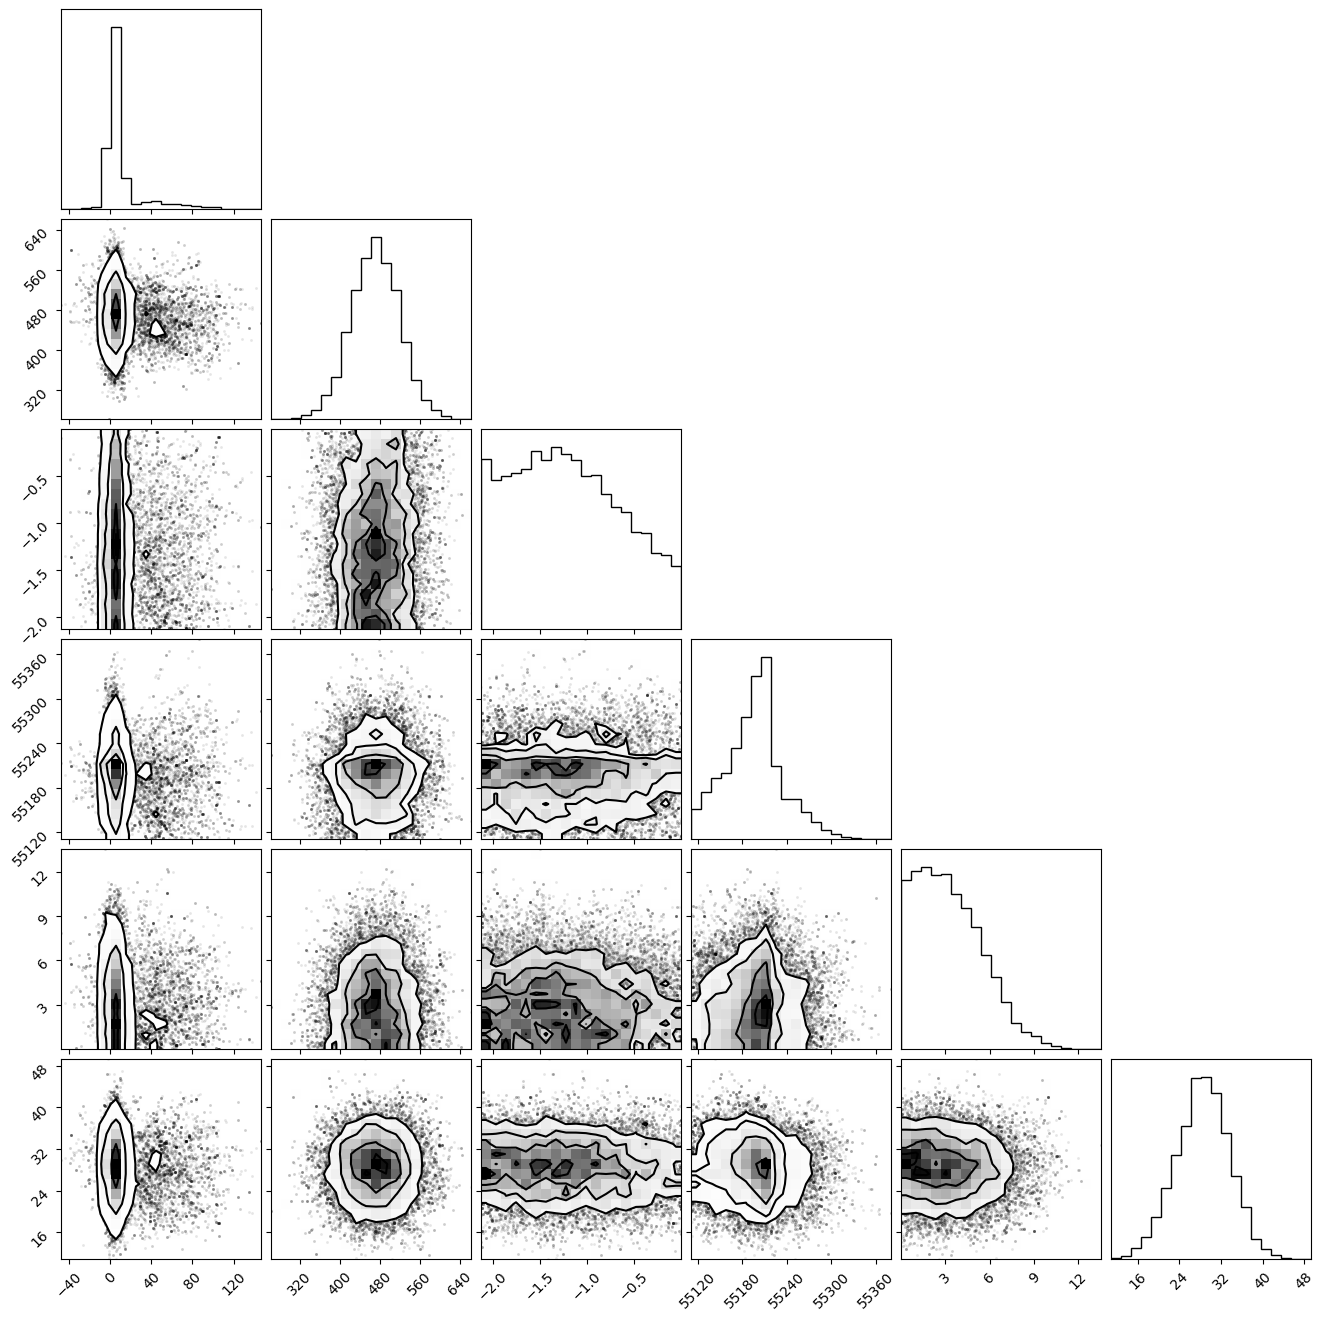

In [121]:
#plot the corner plot
import corner

fig = corner.corner(
    sample2
);

In [122]:
#print the median of all the parameters
print("median of gamma:", np.median(sample2[:,0]))
print("median of A:", np.median(sample2[:,1]))
print("median of beta:", np.median(sample2[:,2]))
print("median of t0:", np.median(sample2[:,3]))
print("median of tau_rise:", np.median(sample2[:,4]))
print("median of tau_fall:", np.median(sample2[:,5]))
theta_pre = [np.median(sample2[:,0]),np.median(sample2[:,1]),np.median(sample2[:,2]),np.mean(sample2[:,3]),np.median(sample2[:,4]),np.median(sample2[:,5])]

median of gamma: 5.312294693578144
median of A: 471.21735955369513
median of beta: -1.2419083401357929
median of t0: 55197.38131495823
median of tau_rise: 3.0288907721928937
median of tau_fall: 28.564444174262018


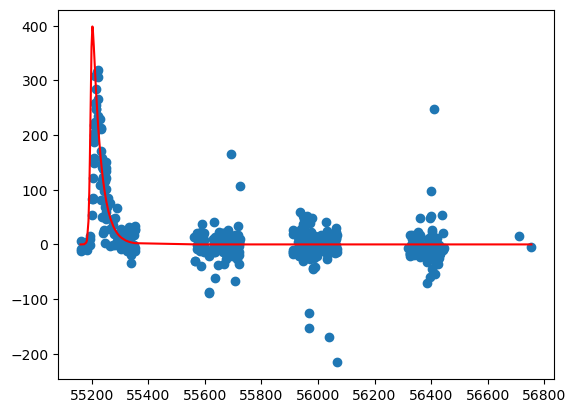

In [123]:
plt.plot(sorted(t),model(theta_pre,sorted(t)),color='r')
plt.scatter(t,flux)

In [ ]:
autocorr2 = emcee.autocorr.integrated_time(sampler2g.get_chain())
autocorr2_thin = emcee.autocorr.integrated_time(sampler2g.get_chain()[0::10])

In [129]:
print('autocorelation length:',autocorr2)
print('autocorelation length after thining:',autocorr2_thin)

autocorelation length: [105.01509855, 80.9299457, 84.76161441, 72.96027689, 61.49565618, 62.4881401]
autocorelation length after thining: [10.27402907, 8.15583134, 8.59036767, 7.3639832, 6.0729992, 6.19381571]
